In [53]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk

In [2]:
file_id = '1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV'
url = f'https://drive.google.com/uc?id={file_id}'
output_name = 'Fraud_Detection.csv'

gdown.download(url, output_name, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV
From (redirected): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV&confirm=t&uuid=16f6a0c4-9475-4c92-9729-c1c9c5a26e75
To: /content/Fraud_Detection.csv
100%|██████████| 494M/494M [00:04<00:00, 121MB/s] 


'Fraud_Detection.csv'

In [44]:
Data=pd.read_csv(r'/content/Fraud_Detection.csv')
Data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# On looking at the data their seems some un-important features

*   nameDest -> 2722362 unique values
*   namOrig -> 6353307 unique values
*   isFlaggedFraud -> Doesn't mean sense to use on training
*   Step -> not useful in classification training

### and we can't categorize it due to high unique counts. so i decided to remove it.


In [45]:
Data=Data.drop(['nameDest','nameOrig','isFlaggedFraud','step'],axis=1)
Data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


# The data appears highly imbalanced due to a significant difference in the target value counts:

* 0 (False) --> 6,354,407 occurrences
* 1 (True) --> 8,213 occurrences

### Let's keep it balanced for fair integrity

In [37]:
Data['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [47]:
# Randomly choosing same 8213 rows from the non fraud & isFraud features
nonFraud=Data[Data['isFraud']==0].sample(frac=1)[:8213]
isFraud=Data[Data['isFraud']==1]

Data=pd.concat([nonFraud, isFraud], ignore_index=True)
Data=Data.sample(frac=1).reset_index(drop=True)

In [48]:
print(Data['isFraud'].value_counts())
print('Size of Curated Data:',len(Data),end='\n')
print('----'*30)
Data.head()

isFraud
1    8213
0    8213
Name: count, dtype: int64
Size of Curated Data: 16426
------------------------------------------------------------------------------------------------------------------------


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,40013.19,40013.19,0.00,0.00,0.00,1
1,CASH_OUT,42966.31,16509.00,0.00,1680647.17,1723613.48,0
2,PAYMENT,16140.19,5082.00,0.00,0.00,0.00,0
3,CASH_IN,142894.02,4631733.16,4774627.18,5463767.56,5320873.54,0
4,TRANSFER,87442.62,20011.00,0.00,432277.71,519720.33,0


# Let's categorize and Scale down Features

In [51]:
Data['type']=Data['type'].replace({'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,'DEBIT':4,'CASH_IN':5})
Data['amount']=Data['amount']/Data['amount'].mean()                                               # Mean -> 822415.1270540606
Data['oldbalanceOrg']=Data['oldbalanceOrg']/Data['oldbalanceOrg'].mean()                          # Mean -> 1251288.2052246442
Data['newbalanceOrig']=Data['newbalanceOrig']/Data['newbalanceOrig'].mean()                       # Mean -> 534174.8091549982
Data['oldbalanceDest']=Data['oldbalanceDest']/Data['oldbalanceDest'].mean()                       # Mean -> 837583.1441598685
Data['newbalanceDest']=Data['newbalanceDest']/Data['newbalanceDest'].mean()                       # Mean -> 1265554.3137051016

/tmp/ipython-input-51-2675914300.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['type']=Data['type'].replace({'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,'DEBIT':4,'CASH_IN':5})


In [52]:
Data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,2,0.048653,0.031978,0.000000,0.000000,0.000000,1
1,3,0.052244,0.013194,0.000000,2.006544,1.361944,0
2,1,0.019625,0.004061,0.000000,0.000000,0.000000,0
3,5,0.173749,3.701572,8.938323,6.523254,4.204382,0
4,2,0.106324,0.015992,0.000000,0.516101,0.410666,0


# Spliting data into training and test

In [54]:
X=Data.drop(['isFraud'],axis=1)
y=Data['isFraud']
X_train, X_test, y_train, y_test=sk.model_selection.train_test_split(X,y, test_size=0.2, stratify=y)

# Step1: Using Deep learning based classification architecture

In [58]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7382 - loss: 0.5025 - val_accuracy: 0.8950 - val_loss: 0.2563
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9165 - loss: 0.2210 - val_accuracy: 0.9510 - val_loss: 0.1393
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9414 - loss: 0.1647 - val_accuracy: 0.9492 - val_loss: 0.1278
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9578 - loss: 0.1143 - val_accuracy: 0.9614 - val_loss: 0.0990
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1115 - val_accuracy: 0.9662 - val_loss: 0.0918
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9685 - loss: 0.0924 - val_accuracy: 0.9650 - val_loss: 0.0964
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9727 - loss: 0.0803 - val_accuracy: 0.9741 - val_loss: 0.0814
Epoch 8/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9734 - loss: 0.0791 - val_accuracy: 0.

# So as of result The model performed very well on Train and Test dataset 💯

### this sharply denotes the handling of model architecture and Effective data cleaning

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 Score: 0.9777371149740774
------------------------------------------------------------------------------------------------------------------------


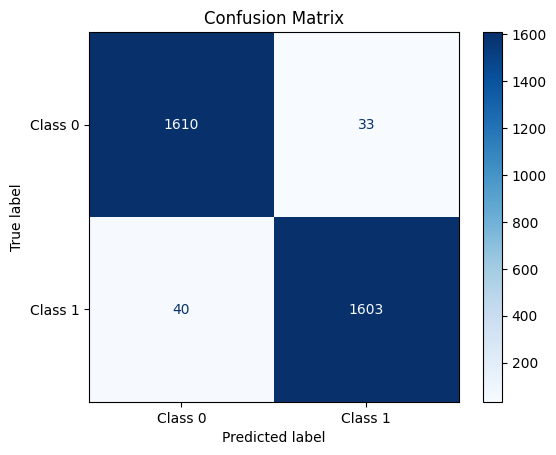

In [67]:
y_pred_probs=model.predict(X_test)
y_pred=(y_pred_probs > 0.5).astype("int32")  # converting probabilities to binary class

print('F1 Score:',sk.metrics.f1_score(y_test, y_pred))
print('----'*30)

cm=sk.metrics.confusion_matrix(y_test, y_pred)

disp=sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step2: Train on Machine learning based classification algorithm (Random Forest)

In [62]:
model2=sk.ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# So Random forest also performed well on unseen dataset 💯

F1 Score: 0.9899909008189263
------------------------------------------------------------------------------------------------------------------------


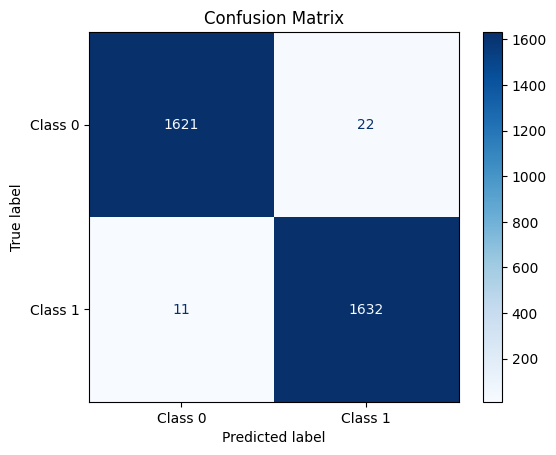

In [66]:
y_pred2=model2.predict(X_test)
print('F1 Score:',sk.metrics.f1_score(y_test, y_pred2))
print('----'*30)
cm=sk.metrics.confusion_matrix(y_test, y_pred2)

disp=sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Some Answers of your question



---



1. Data cleaning including missing values, outliers and multi-collinearity.  
- have used various cleaning techniques to make dataset robust and valuable during training


---



2. Describe your fraud detection model in elaboration.  
- Built two models: a **Neural Network (Deep Learning) and Random Forest (Machine Learning)**. Random Forest performed better in accuracy and F1-score.


---



3. How did you select variables to be included in the model?
- Selected important features based on domain knowledge and relevance to fraudulent patterns. Focused on variables with high influence on outcomes.


---



4. Demonstrate the performance of the model by using best set of tools.
- Evaluated using **Confusion Matrix, Accuracy, and F1 Score** to balance between false positives and false negatives.


---



5. What are the key factors that predict fraudulent customer?
- Important features: **type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest**. These features reflect transaction behavior.


---


6. Do these factors make sense? If yes, How? If not, How not?
- Yes, the selected features make sense for predicting fraud. but Features like **nameDest, nameOrig, step, and isFlaggedFraud** had low impact and were excluded.


---


7. What kind of prevention should be adopted while company update its infrastructure?
- Implement **real-time fraud detection systems, encryption, frequent audits, user verification (KYC), and behavior-based anomaly detection**.


---


8. Assuming these actions have been implemented, how would you determine if they work?
- Monitor **post-implementation fraud rates, compare precision-recall scores, run A/B tests, and review transaction anomaly reports**.

---

